In [34]:
# Part 1: Setup and Imports for Online News Popularity Analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set random state for reproducibility
RANDOM_STATE = 42

# Configure plotting
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12
sns.set_style("whitegrid")

print("All imports successful!")
print("Ready to analyze Online News Popularity dataset")
print("Dataset source: UCI Machine Learning Repository")
print("Original paper: Fernandes, K., Vinagre, P. and Cortez, P. (2015)")
print("=" * 60)

All imports successful!
Ready to analyze Online News Popularity dataset
Dataset source: UCI Machine Learning Repository
Original paper: Fernandes, K., Vinagre, P. and Cortez, P. (2015)


In [35]:
# Part 2: Data Loading and Initial Exploration
print("Loading Online News Popularity dataset...")

path = "data/OnlineNewsPopularity.csv"

df = pd.read_csv(path)

# Display basic information about the dataset
print(f"\nDataset shape: {df.shape}")
print(f"Number of articles: {df.shape[0]:,}")
print(f"Number of variables: {df.shape[1]}")

# Display column names
print(f"\nColumn names:")
print(df.columns.tolist())

# Display first few rows
print(f"\nFirst 5 rows:")
print(df.head())

# Basic info about the dataset
print(f"\nDataset info:")
print(df.info())

# Check for missing values
missing_values = df.isnull().sum()
if missing_values.sum() > 0:
    print(f"\nMissing values:")
    print(missing_values[missing_values > 0])
else:
    print(f"\nNo missing values found! ✓")

# Display summary statistics for shares (our target variable)
print(f"\nShares variable summary:")
print(df[' shares'].describe())

Loading Online News Popularity dataset...

Dataset shape: (39644, 61)
Number of articles: 39,644
Number of variables: 61

Column names:
['url', ' timedelta', ' n_tokens_title', ' n_tokens_content', ' n_unique_tokens', ' n_non_stop_words', ' n_non_stop_unique_tokens', ' num_hrefs', ' num_self_hrefs', ' num_imgs', ' num_videos', ' average_token_length', ' num_keywords', ' data_channel_is_lifestyle', ' data_channel_is_entertainment', ' data_channel_is_bus', ' data_channel_is_socmed', ' data_channel_is_tech', ' data_channel_is_world', ' kw_min_min', ' kw_max_min', ' kw_avg_min', ' kw_min_max', ' kw_max_max', ' kw_avg_max', ' kw_min_avg', ' kw_max_avg', ' kw_avg_avg', ' self_reference_min_shares', ' self_reference_max_shares', ' self_reference_avg_sharess', ' weekday_is_monday', ' weekday_is_tuesday', ' weekday_is_wednesday', ' weekday_is_thursday', ' weekday_is_friday', ' weekday_is_saturday', ' weekday_is_sunday', ' is_weekend', ' LDA_00', ' LDA_01', ' LDA_02', ' LDA_03', ' LDA_04', ' glo

Preprocessing the data...
Shares statistics:
Min: 1
Median: 1,400.0
Mean: 3395
Max: 843,300
Standard deviation: 11627


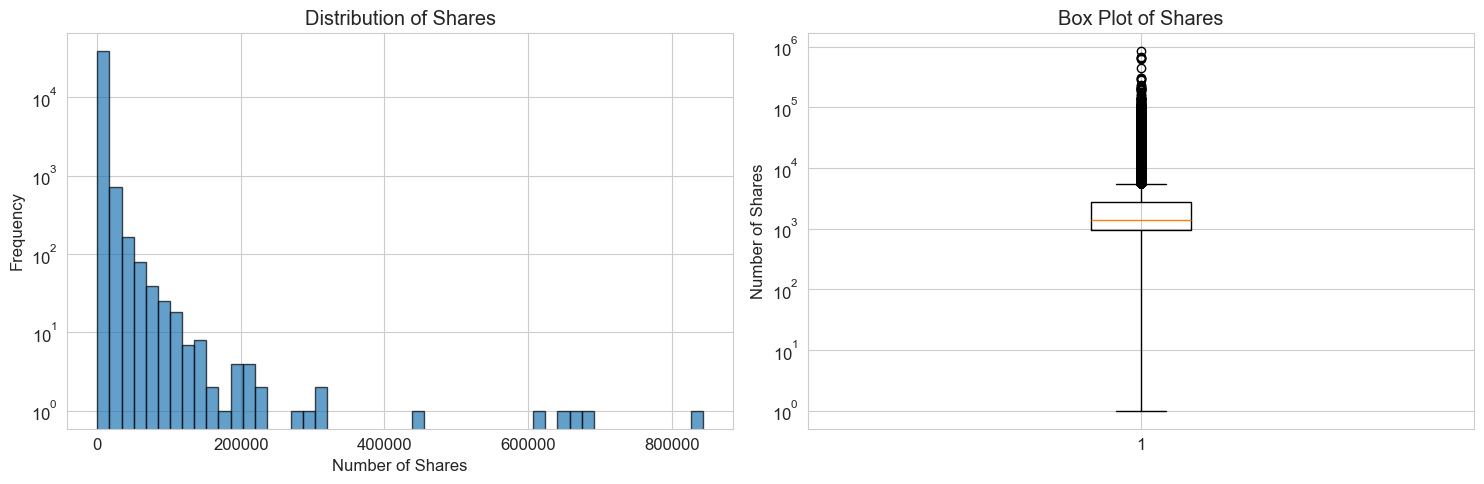


Using median (1,400.0 shares) as threshold for popularity
Popular articles (> median): 19,562 (49.3%)
Unpopular articles (≤ median): 20,082 (50.7%)

Dropping columns: ['url', ' timedelta', ' shares']

Feature matrix shape: (39644, 58)
Target array shape: (39644,)
Number of predictor variables: 58

First 10 predictor variables:
   1.  n_tokens_title
   2.  n_tokens_content
   3.  n_unique_tokens
   4.  n_non_stop_words
   5.  n_non_stop_unique_tokens
   6.  num_hrefs
   7.  num_self_hrefs
   8.  num_imgs
   9.  num_videos
  10.  average_token_length
  ... and 48 more variables

Feature value ranges:
Min value across all features: -1.000
Max value across all features: 843300.000
Mean value across all features: 18240.471

Data preprocessing complete!
Ready for classification with 39,644 samples and 58 features


In [36]:
# Part 3: Data Preprocessing
print("Preprocessing the data...")

# First, let's examine the shares variable in detail
shares = df[' shares']
print(f"Shares statistics:")
print(f"Min: {shares.min():,}")
print(f"Median: {shares.median():,}")
print(f"Mean: {shares.mean():.0f}")
print(f"Max: {shares.max():,}")
print(f"Standard deviation: {shares.std():.0f}")

# Visualize the distribution of shares
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Histogram of shares (with log scale due to high skewness)
ax1.hist(shares, bins=50, edgecolor='black', alpha=0.7)
ax1.set_xlabel('Number of Shares')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Shares')
ax1.set_yscale('log')

# Box plot to show outliers
ax2.boxplot(shares)
ax2.set_ylabel('Number of Shares')
ax2.set_title('Box Plot of Shares')
ax2.set_yscale('log')

plt.tight_layout()
plt.show()

# Create binary popularity variable based on median
median_shares = shares.median()
print(f"\nUsing median ({median_shares:,} shares) as threshold for popularity")

# Create binary target variable
y = (shares > median_shares).astype(int)
print(f"Popular articles (> median): {y.sum():,} ({y.mean()*100:.1f}%)")
print(f"Unpopular articles (≤ median): {(1-y).sum():,} ({(1-y.mean())*100:.1f}%)")

# Remove columns we don't need for prediction
columns_to_drop = ['url', ' timedelta', ' shares']
print(f"\nDropping columns: {columns_to_drop}")

# Create feature matrix X
X_df = df.drop(columns=columns_to_drop)
X = X_df.values
feature_names = X_df.columns.tolist()

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target array shape: {y.shape}")
print(f"Number of predictor variables: {len(feature_names)}")

# Display first few feature names
print(f"\nFirst 10 predictor variables:")
for i, name in enumerate(feature_names[:10]):
    print(f"  {i+1:2d}. {name}")

print(f"  ... and {len(feature_names)-10} more variables")

# Check feature ranges
print(f"\nFeature value ranges:")
print(f"Min value across all features: {X.min():.3f}")
print(f"Max value across all features: {X.max():.3f}")
print(f"Mean value across all features: {X.mean():.3f}")

# Save the processed data for later use
print(f"\nData preprocessing complete!")
print(f"Ready for classification with {X.shape[0]:,} samples and {X.shape[1]} features")

Performing exploratory data analysis...


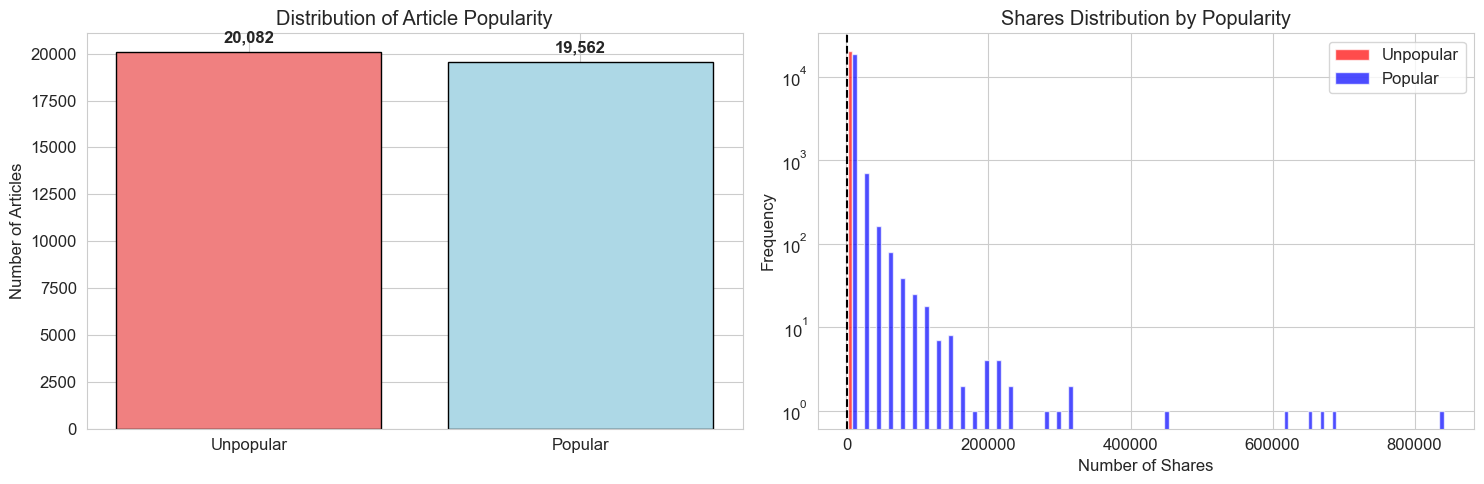

Examining variables: [' n_tokens_title', ' n_tokens_content', ' num_imgs', ' num_videos', ' weekday_is_monday', ' weekday_is_sunday']

 n_tokens_title:
  Unpopular articles - Mean: 10.49, Median: 10.00
  Popular articles   - Mean: 10.31, Median: 10.00

 n_tokens_content:
  Unpopular articles - Mean: 527.76, Median: 408.00
  Popular articles   - Mean: 565.77, Median: 411.00

 num_imgs:
  Unpopular articles - Mean: 3.99, Median: 1.00
  Popular articles   - Mean: 5.11, Median: 1.00

 num_videos:
  Unpopular articles - Mean: 1.21, Median: 0.00
  Popular articles   - Mean: 1.29, Median: 0.00


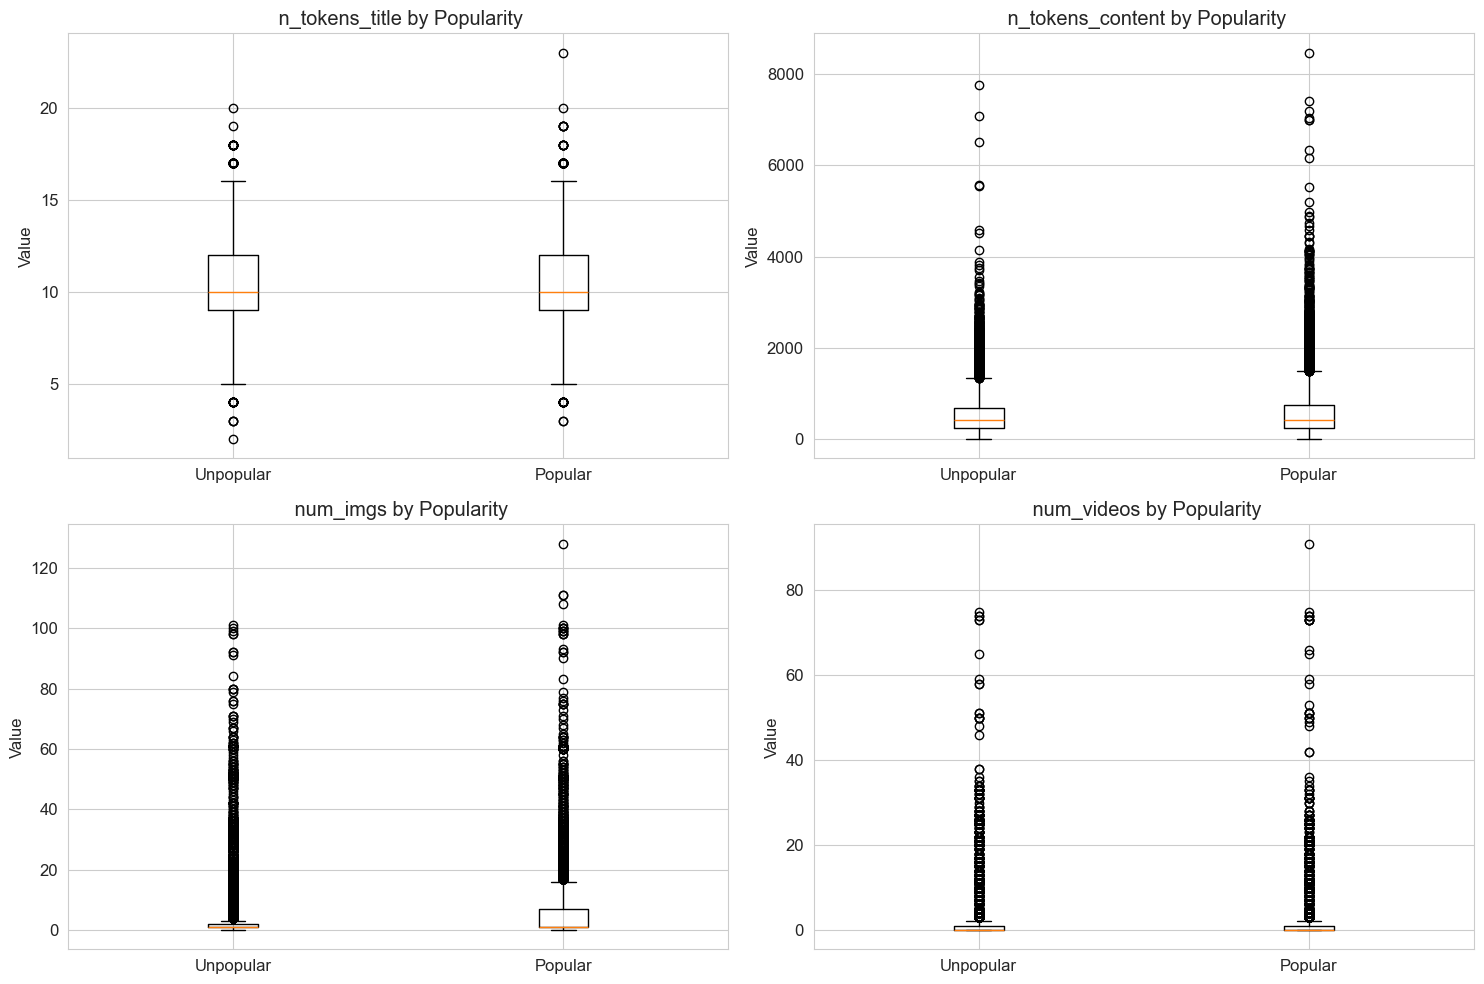


Checking for extreme values...
Features with potential outliers (top 10):
   kw_min_max: max=843300.0, mean=13612.4
   kw_avg_max: max=843300.0, mean=259281.9
   self_reference_min_shares: max=843300.0, mean=3998.8
   self_reference_max_shares: max=843300.0, mean=10329.2
   self_reference_avg_sharess: max=843300.0, mean=6401.7
   kw_max_min: max=298400.0, mean=1154.0
   kw_max_avg: max=298400.0, mean=5657.2
   kw_avg_avg: max=43567.7, mean=3135.9
   kw_avg_min: max=42827.9, mean=312.4
   n_tokens_content: max=8474.0, mean=546.5

Correlation analysis...


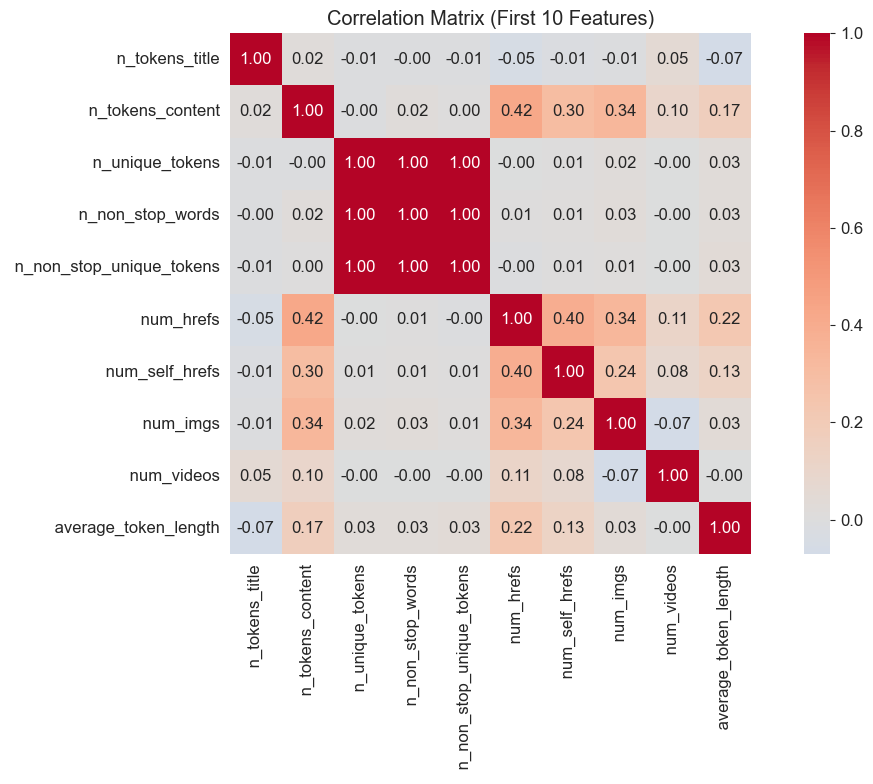


Feature statistics summary:
Number of binary features (only 0s and 1s): 14
Number of features with zero variance: 0
Number of features with negative values: 8

Exploratory data analysis complete!
Data appears to be reasonable for classification tasks.


In [37]:
# Part 4: Exploratory Data Analysis
print("Performing exploratory data analysis...")

# 1. Examine the target variable distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Distribution of popularity
popularity_counts = y.value_counts()
ax1.bar(['Unpopular', 'Popular'], [popularity_counts[0], popularity_counts[1]],
        color=['lightcoral', 'lightblue'], edgecolor='black')
ax1.set_ylabel('Number of Articles')
ax1.set_title('Distribution of Article Popularity')
for i, count in enumerate([popularity_counts[0], popularity_counts[1]]):
    ax1.text(i, count + 500, f'{count:,}', ha='center', fontweight='bold')

# Shares distribution by popularity
popular_shares = shares[y == 1]
unpopular_shares = shares[y == 0]

ax2.hist([unpopular_shares, popular_shares], bins=50, alpha=0.7,
         label=['Unpopular', 'Popular'], color=['red', 'blue'])
ax2.set_xlabel('Number of Shares')
ax2.set_ylabel('Frequency')
ax2.set_title('Shares Distribution by Popularity')
ax2.set_yscale('log')
ax2.legend()
ax2.axvline(median_shares, color='black', linestyle='--', label=f'Median: {median_shares:,}')

plt.tight_layout()
plt.show()

# 2. Examine some key predictor variables
# Let's look at a few interesting variables
interesting_vars = [
    ' n_tokens_title',      # Number of words in title
    ' n_tokens_content',    # Number of words in content
    ' num_imgs',           # Number of images
    ' num_videos',         # Number of videos
    ' weekday_is_monday',  # Published on Monday
    ' weekday_is_sunday'   # Published on Sunday
]

# Check if these variables exist in our dataset
available_vars = [var for var in interesting_vars if var in X_df.columns]
print(f"Examining variables: {available_vars}")

if len(available_vars) >= 4:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()

    for i, var in enumerate(available_vars[:4]):
        var_data = X_df[var]

        # Create box plots comparing popular vs unpopular articles
        data_to_plot = [var_data[y == 0], var_data[y == 1]]
        axes[i].boxplot(data_to_plot, labels=['Unpopular', 'Popular'])
        axes[i].set_title(f'{var} by Popularity')
        axes[i].set_ylabel('Value')

        # Print some statistics
        print(f"\n{var}:")
        print(f"  Unpopular articles - Mean: {var_data[y == 0].mean():.2f}, Median: {var_data[y == 0].median():.2f}")
        print(f"  Popular articles   - Mean: {var_data[y == 1].mean():.2f}, Median: {var_data[y == 1].median():.2f}")

    plt.tight_layout()
    plt.show()

# 3. Check for extreme values and outliers
print(f"\nChecking for extreme values...")
extreme_features = []
for i, feature in enumerate(feature_names):
    feature_data = X[:, i]
    q1, q3 = np.percentile(feature_data, [25, 75])
    iqr = q3 - q1
    outlier_threshold = q3 + 1.5 * iqr

    if feature_data.max() > outlier_threshold:
        extreme_features.append((feature, feature_data.max(), feature_data.mean()))

print(f"Features with potential outliers (top 10):")
extreme_features.sort(key=lambda x: x[1], reverse=True)
for feature, max_val, mean_val in extreme_features[:10]:
    print(f"  {feature}: max={max_val:.1f}, mean={mean_val:.1f}")

# 4. Correlation analysis (sample of features)
print(f"\nCorrelation analysis...")
# Select a subset of features for correlation analysis
sample_features = X_df.iloc[:, :10]  # First 10 features
correlation_matrix = sample_features.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            fmt='.2f', square=True)
plt.title('Correlation Matrix (First 10 Features)')
plt.tight_layout()
plt.show()

# 5. Feature statistics summary
print(f"\nFeature statistics summary:")
print(f"Number of binary features (only 0s and 1s): {np.sum([np.array_equal(X[:, i], X[:, i].astype(bool).astype(int)) for i in range(X.shape[1])])}")
print(f"Number of features with zero variance: {np.sum(X.std(axis=0) == 0)}")
print(f"Number of features with negative values: {np.sum([np.any(X[:, i] < 0) for i in range(X.shape[1])])}")

print(f"\nExploratory data analysis complete!")
print(f"Data appears to be reasonable for classification tasks.")

In [38]:
# Part 5: Data Splitting and Scaling
print("Splitting data into training and testing sets...")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"Training set size: {X_train.shape[0]:,} samples")
print(f"Test set size: {X_test.shape[0]:,} samples")
print(f"Split ratio: {X_train.shape[0]/len(X):.1%} train, {X_test.shape[0]/len(X):.1%} test")

# Verify stratification
train_popular = y_train.mean()
test_popular = y_test.mean()
print(f"\nPopularity distribution:")
print(f"Training set: {train_popular:.3f} ({train_popular*100:.1f}% popular)")
print(f"Test set: {test_popular:.3f} ({test_popular*100:.1f}% popular)")
print(f"Overall: {y.mean():.3f} ({y.mean()*100:.1f}% popular)")

# Scale the features for algorithms that benefit from scaling
print(f"\nScaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Original data - Mean: {X_train.mean():.3f}, Std: {X_train.std():.3f}")
print(f"Scaled data - Mean: {X_train_scaled.mean():.6f}, Std: {X_train_scaled.std():.6f}")

# For SVM experiments, create a smaller subset due to computational constraints
subset_size = 5000
print(f"\nCreating subset of {subset_size:,} samples for SVM experiments...")

# Ensure we maintain class balance in the subset
subset_indices = []
n_popular = int(subset_size * y_train.mean())
n_unpopular = subset_size - n_popular

popular_indices = np.where(y_train == 1)[0]
unpopular_indices = np.where(y_train == 0)[0]

# Randomly sample from each class
np.random.seed(RANDOM_STATE)
subset_indices.extend(np.random.choice(popular_indices, n_popular, replace=False))
subset_indices.extend(np.random.choice(unpopular_indices, n_unpopular, replace=False))
subset_indices = np.array(subset_indices)

X_train_subset = X_train_scaled[subset_indices]
y_train_subset = y_train[subset_indices]

print(f"Subset size: {X_train_subset.shape[0]:,} samples")
print(f"Subset popularity: {y_train_subset.mean():.3f} ({y_train_subset.mean()*100:.1f}% popular)")

# Summary of datasets prepared
print(f"\nDatasets prepared:")
print(f"1. Full training set: {X_train.shape[0]:,} samples (original scale)")
print(f"2. Full training set: {X_train_scaled.shape[0]:,} samples (scaled)")
print(f"3. Subset for SVM: {X_train_subset.shape[0]:,} samples (scaled)")
print(f"4. Test set: {X_test.shape[0]:,} samples (original scale)")
print(f"5. Test set: {X_test_scaled.shape[0]:,} samples (scaled)")

print(f"\nData splitting and scaling complete!")
print(f"Ready for classification experiments.")

Splitting data into training and testing sets...
Training set size: 31,715 samples
Test set size: 7,929 samples
Split ratio: 80.0% train, 20.0% test

Popularity distribution:
Training set: 0.493 (49.3% popular)
Test set: 0.493 (49.3% popular)
Overall: 0.493 (49.3% popular)

Scaling features...
Original data - Mean: 18201.989, Std: 108527.620
Scaled data - Mean: 0.000000, Std: 1.000000

Creating subset of 5,000 samples for SVM experiments...
Subset size: 5,000 samples
Subset popularity: 0.493 (49.3% popular)

Datasets prepared:
1. Full training set: 31,715 samples (original scale)
2. Full training set: 31,715 samples (scaled)
3. Subset for SVM: 5,000 samples (scaled)
4. Test set: 7,929 samples (original scale)
5. Test set: 7,929 samples (scaled)

Data splitting and scaling complete!
Ready for classification experiments.


K-NEAREST NEIGHBORS CLASSIFICATION

Finding optimal k value using cross-validation...
Running cross-validation (this may take a few minutes)...
Testing k = 1...
Testing k = 5...
Testing k = 10...
Testing k = 15...
Testing k = 20...
Testing k = 25...
Testing k = 30...

Optimal k value: 29
Best cross-validation score: 0.6315 (63.15%)


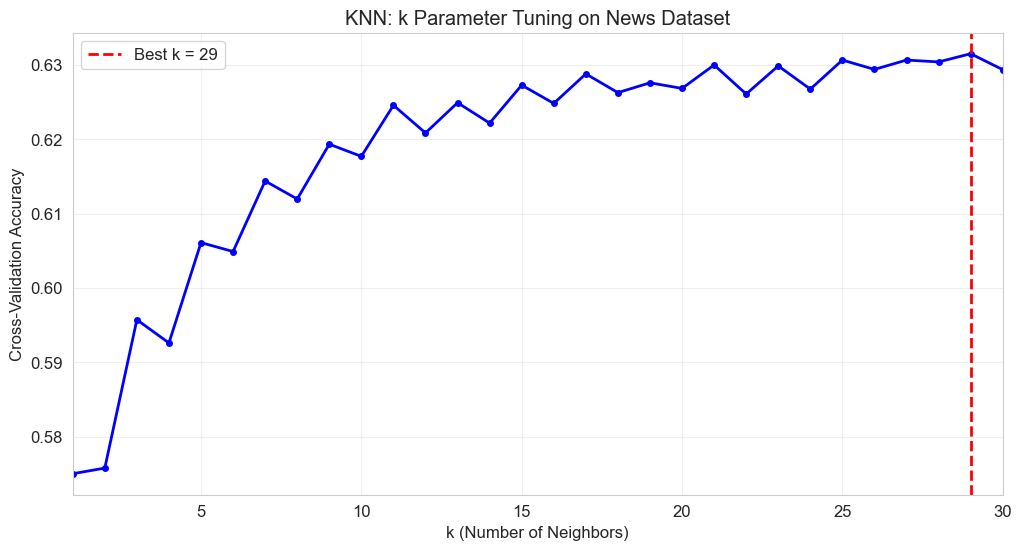


Top 5 k values:
Rank | k Value | CV Score
-------------------------
 1   |   29    | 0.6315 ★
 2   |   27    | 0.6306
 3   |   25    | 0.6306
 4   |   28    | 0.6304
 5   |   21    | 0.6300

Training final KNN model with k=29...
KNN Test Accuracy: 0.6418 (64.18%)

Detailed Classification Report:
              precision    recall  f1-score   support

   Unpopular       0.63      0.69      0.66      4017
     Popular       0.65      0.59      0.62      3912

    accuracy                           0.64      7929
   macro avg       0.64      0.64      0.64      7929
weighted avg       0.64      0.64      0.64      7929



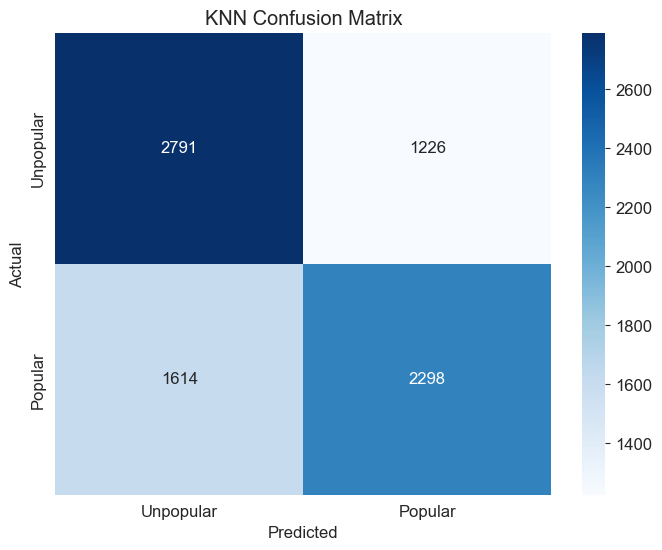


Prediction Analysis:
Correct predictions: 5,089 out of 7,929
Incorrect predictions: 2,840

Class-specific accuracy:
Popular articles: 0.5874 (58.74%)
Unpopular articles: 0.6948 (69.48%)

KNN analysis complete!
Best KNN model: k=29, Test Accuracy=0.6418


In [39]:
# Part 6: KNN Classification
print("="*60)
print("K-NEAREST NEIGHBORS CLASSIFICATION")
print("="*60)

print("\nFinding optimal k value using cross-validation...")

# Test different k values
k_values = range(1, 31)  # Test k from 1 to 30
cv_scores_knn = []

print("Running cross-validation (this may take a few minutes)...")
for k in k_values:
    if k % 5 == 0 or k == 1:  # Progress indicator
        print(f"Testing k = {k}...")

    knn = KNeighborsClassifier(n_neighbors=k)
    # Use 5-fold cross validation
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='accuracy')
    cv_scores_knn.append(scores.mean())

# Find best k
best_k_idx = np.argmax(cv_scores_knn)
best_k = k_values[best_k_idx]
best_cv_score = cv_scores_knn[best_k_idx]

print(f"\nOptimal k value: {best_k}")
print(f"Best cross-validation score: {best_cv_score:.4f} ({best_cv_score*100:.2f}%)")

# Plot k vs accuracy
plt.figure(figsize=(12, 6))
plt.plot(k_values, cv_scores_knn, 'b-', linewidth=2, marker='o', markersize=4)
plt.axvline(x=best_k, color='r', linestyle='--', linewidth=2,
           label=f'Best k = {best_k}')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Cross-Validation Accuracy')
plt.title('KNN: k Parameter Tuning on News Dataset')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(1, 30)
plt.show()

# Show top 5 k values
top_k_indices = np.argsort(cv_scores_knn)[-5:][::-1]
print(f"\nTop 5 k values:")
print("Rank | k Value | CV Score")
print("-" * 25)
for rank, idx in enumerate(top_k_indices):
    k_val = k_values[idx]
    score = cv_scores_knn[idx]
    marker = " ★" if k_val == best_k else ""
    print(f" {rank+1}   |   {k_val:2d}    | {score:.4f}{marker}")

# Train final KNN model with best k
print(f"\nTraining final KNN model with k={best_k}...")
final_knn = KNeighborsClassifier(n_neighbors=best_k)
final_knn.fit(X_train_scaled, y_train)

# Make predictions on test set
y_pred_knn = final_knn.predict(X_test_scaled)
knn_test_accuracy = accuracy_score(y_test, y_pred_knn)

print(f"KNN Test Accuracy: {knn_test_accuracy:.4f} ({knn_test_accuracy*100:.2f}%)")

# Classification report
print(f"\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_knn, target_names=['Unpopular', 'Popular']))

# Confusion matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Unpopular', 'Popular'],
           yticklabels=['Unpopular', 'Popular'])
plt.title('KNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Analyze predictions
correct_predictions = np.sum(y_test == y_pred_knn)
total_predictions = len(y_test)
print(f"\nPrediction Analysis:")
print(f"Correct predictions: {correct_predictions:,} out of {total_predictions:,}")
print(f"Incorrect predictions: {total_predictions - correct_predictions:,}")

# Performance by class
popular_mask = (y_test == 1)
unpopular_mask = (y_test == 0)

popular_accuracy = accuracy_score(y_test[popular_mask], y_pred_knn[popular_mask])
unpopular_accuracy = accuracy_score(y_test[unpopular_mask], y_pred_knn[unpopular_mask])

print(f"\nClass-specific accuracy:")
print(f"Popular articles: {popular_accuracy:.4f} ({popular_accuracy*100:.2f}%)")
print(f"Unpopular articles: {unpopular_accuracy:.4f} ({unpopular_accuracy*100:.2f}%)")

print(f"\nKNN analysis complete!")
print(f"Best KNN model: k={best_k}, Test Accuracy={knn_test_accuracy:.4f}")

SUPPORT VECTOR MACHINE CLASSIFICATION
Using subset of 5,000 samples due to computational constraints...
Note: SVM is computationally expensive on large datasets!

Testing C values: [0.1, 0.5, 1, 5, 10, 50, 100]
This may take several minutes...
Testing C = 0.1...
  CV Score: 0.6354, Time: 1.9s
Testing C = 0.5...
  CV Score: 0.6506, Time: 1.8s
Testing C = 1...
  CV Score: 0.6508, Time: 1.8s
Testing C = 5...
  CV Score: 0.6296, Time: 1.9s
Testing C = 10...
  CV Score: 0.6210, Time: 2.1s
Testing C = 50...
  CV Score: 0.6000, Time: 2.4s
Testing C = 100...
  CV Score: 0.5978, Time: 2.5s

Optimal C value: 1
Best cross-validation score: 0.6508 (65.08%)


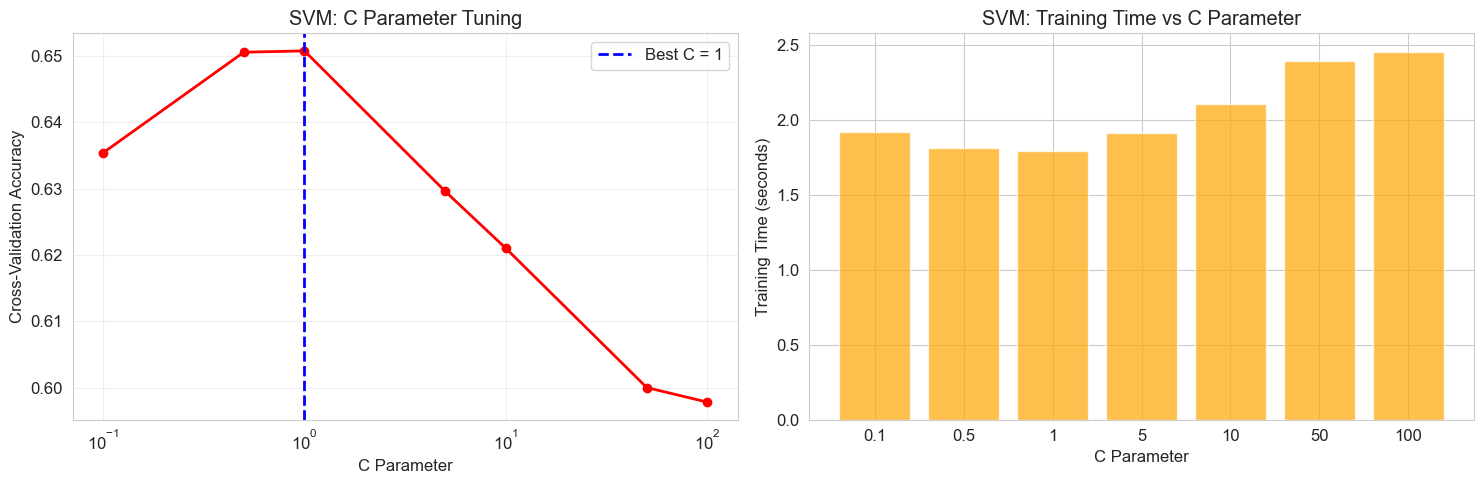


Detailed results:
C Value | CV Score | Time (s)
------------------------------
   0.1  | 0.6354  |    1.9
   0.5  | 0.6506  |    1.8
   1.0  | 0.6508  |    1.8 ★
   5.0  | 0.6296  |    1.9
  10.0  | 0.6210  |    2.1
  50.0  | 0.6000  |    2.4
 100.0  | 0.5978  |    2.5

Training final SVM model with C=1 on subset...
SVM Test Accuracy (trained on subset): 0.6445 (64.45%)

Attempting to train SVM on full dataset with C=1...
This may take several minutes...
SVM Test Accuracy (trained on full data): 0.6604 (66.04%)
Training time on full dataset: 32.6 seconds

Detailed Classification Report:
              precision    recall  f1-score   support

   Unpopular       0.66      0.68      0.67      4017
     Popular       0.66      0.64      0.65      3912

    accuracy                           0.66      7929
   macro avg       0.66      0.66      0.66      7929
weighted avg       0.66      0.66      0.66      7929



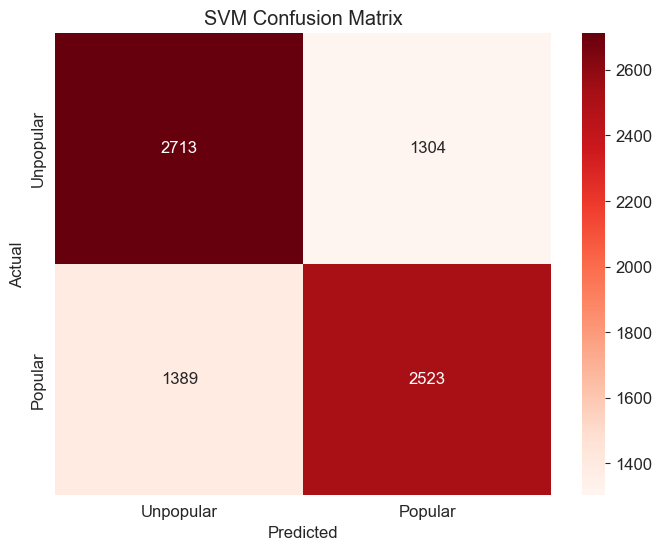


SVM analysis complete!
Best SVM model: C=1, Test Accuracy=0.6604


In [40]:
# Part 7: SVM Classification
print("="*60)
print("SUPPORT VECTOR MACHINE CLASSIFICATION")
print("="*60)

print(f"Using subset of {X_train_subset.shape[0]:,} samples due to computational constraints...")
print("Note: SVM is computationally expensive on large datasets!")

# Test different C values
C_values = [0.1, 0.5, 1, 5, 10, 50, 100]
cv_scores_svm = []
fit_times = []

print(f"\nTesting C values: {C_values}")
print("This may take several minutes...")

import time

for C in C_values:
    print(f"Testing C = {C}...")
    start_time = time.time()

    svm = SVC(kernel='rbf', C=C, random_state=RANDOM_STATE)
    # Use 3-fold CV on subset to save time
    scores = cross_val_score(svm, X_train_subset, y_train_subset, cv=3, scoring='accuracy')
    cv_scores_svm.append(scores.mean())

    fit_time = time.time() - start_time
    fit_times.append(fit_time)
    print(f"  CV Score: {scores.mean():.4f}, Time: {fit_time:.1f}s")

# Find best C
best_C_idx = np.argmax(cv_scores_svm)
best_C = C_values[best_C_idx]
best_svm_cv_score = cv_scores_svm[best_C_idx]

print(f"\nOptimal C value: {best_C}")
print(f"Best cross-validation score: {best_svm_cv_score:.4f} ({best_svm_cv_score*100:.2f}%)")

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# C vs Accuracy
ax1.plot(C_values, cv_scores_svm, 'r-', linewidth=2, marker='o', markersize=6)
ax1.axvline(x=best_C, color='blue', linestyle='--', linewidth=2,
           label=f'Best C = {best_C}')
ax1.set_xlabel('C Parameter')
ax1.set_ylabel('Cross-Validation Accuracy')
ax1.set_title('SVM: C Parameter Tuning')
ax1.set_xscale('log')
ax1.legend()
ax1.grid(True, alpha=0.3)

# C vs Training Time
ax2.bar(range(len(C_values)), fit_times, color='orange', alpha=0.7)
ax2.set_xlabel('C Parameter')
ax2.set_ylabel('Training Time (seconds)')
ax2.set_title('SVM: Training Time vs C Parameter')
ax2.set_xticks(range(len(C_values)))
ax2.set_xticklabels(C_values)

plt.tight_layout()
plt.show()

# Show all results
print(f"\nDetailed results:")
print("C Value | CV Score | Time (s)")
print("-" * 30)
for i, C in enumerate(C_values):
    marker = " ★" if C == best_C else ""
    print(f" {C:5.1f}  | {cv_scores_svm[i]:.4f}  | {fit_times[i]:6.1f}{marker}")

# Train final SVM model with best C on subset
print(f"\nTraining final SVM model with C={best_C} on subset...")
final_svm_subset = SVC(kernel='rbf', C=best_C, random_state=RANDOM_STATE)
final_svm_subset.fit(X_train_subset, y_train_subset)

# Test on the full test set
y_pred_svm_subset = final_svm_subset.predict(X_test_scaled)
svm_subset_test_accuracy = accuracy_score(y_test, y_pred_svm_subset)

print(f"SVM Test Accuracy (trained on subset): {svm_subset_test_accuracy:.4f} ({svm_subset_test_accuracy*100:.2f}%)")

# Try training on full dataset with best C (if computationally feasible)
print(f"\nAttempting to train SVM on full dataset with C={best_C}...")
print("This may take several minutes...")

try:
    start_time = time.time()
    final_svm_full = SVC(kernel='rbf', C=best_C, random_state=RANDOM_STATE)
    final_svm_full.fit(X_train_scaled, y_train)
    full_training_time = time.time() - start_time

    y_pred_svm_full = final_svm_full.predict(X_test_scaled)
    svm_full_test_accuracy = accuracy_score(y_test, y_pred_svm_full)

    print(f"SVM Test Accuracy (trained on full data): {svm_full_test_accuracy:.4f} ({svm_full_test_accuracy*100:.2f}%)")
    print(f"Training time on full dataset: {full_training_time:.1f} seconds")

    # Use full model results for further analysis
    y_pred_svm = y_pred_svm_full
    svm_test_accuracy = svm_full_test_accuracy

except Exception as e:
    print(f"Training on full dataset failed or took too long: {e}")
    print("Using subset-trained model results")
    y_pred_svm = y_pred_svm_subset
    svm_test_accuracy = svm_subset_test_accuracy

# Classification report
print(f"\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_svm, target_names=['Unpopular', 'Popular']))

# Confusion matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Reds',
           xticklabels=['Unpopular', 'Popular'],
           yticklabels=['Unpopular', 'Popular'])
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(f"\nSVM analysis complete!")
print(f"Best SVM model: C={best_C}, Test Accuracy={svm_test_accuracy:.4f}")

DECISION TREE CLASSIFICATION
Tuning Decision Tree parameters using GridSearchCV...
Parameter grid:
  max_depth: [5, 10, 15, 20, 25, None]
  min_samples_split: [2, 5, 10, 20, 50]
Total combinations: 30

Running GridSearchCV (this may take a few minutes)...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best parameters found:
  max_depth: 5
  min_samples_split: 2
Best cross-validation score: 0.6350 (63.50%)


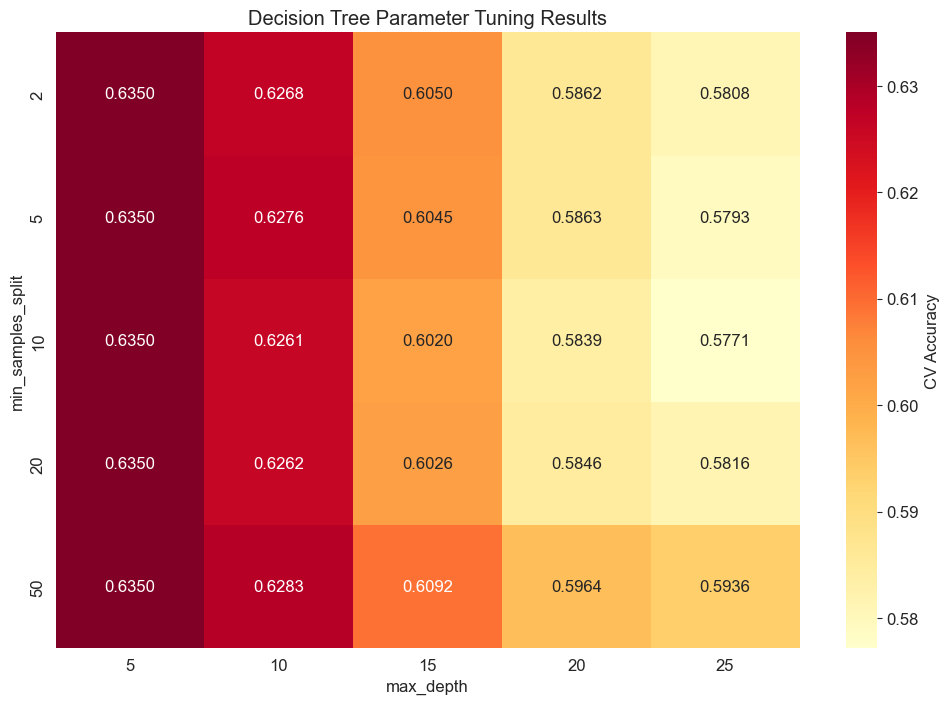


Training final Decision Tree model...
Decision Tree Test Accuracy: 0.6316 (63.16%)

Detailed Classification Report:
              precision    recall  f1-score   support

   Unpopular       0.64      0.64      0.64      4017
     Popular       0.63      0.62      0.63      3912

    accuracy                           0.63      7929
   macro avg       0.63      0.63      0.63      7929
weighted avg       0.63      0.63      0.63      7929



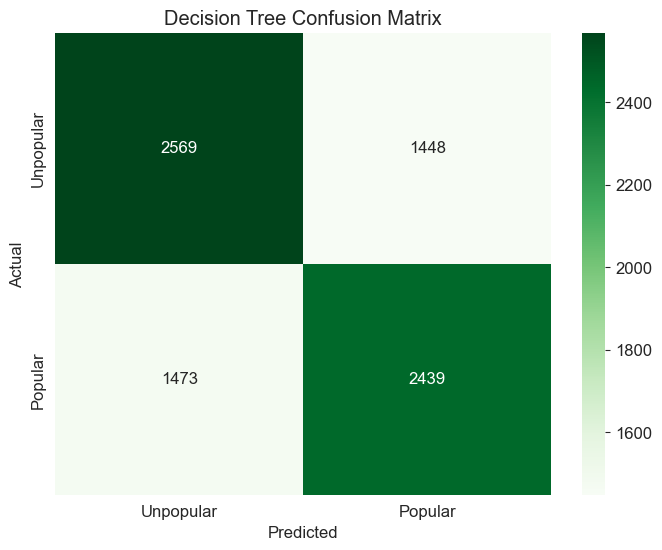


Top 15 Most Important Features:
Rank | Feature                          | Importance
-------------------------------------------------------
  1  |  kw_avg_avg                    | 0.3266
  2  |  is_weekend                    | 0.1391
  3  |  data_channel_is_entertainment | 0.1111
  4  |  data_channel_is_tech          | 0.0907
  5  |  data_channel_is_socmed        | 0.0769
  6  |  self_reference_min_shares     | 0.0697
  7  |  kw_max_max                    | 0.0620
  8  |  LDA_02                        | 0.0223
  9  |  n_unique_tokens               | 0.0172
 10  |  self_reference_avg_sharess    | 0.0130
 11  |  LDA_00                        | 0.0129
 12  |  LDA_01                        | 0.0111
 13  |  kw_min_min                    | 0.0093
 14  |  num_hrefs                     | 0.0070
 15  |  kw_avg_min                    | 0.0062


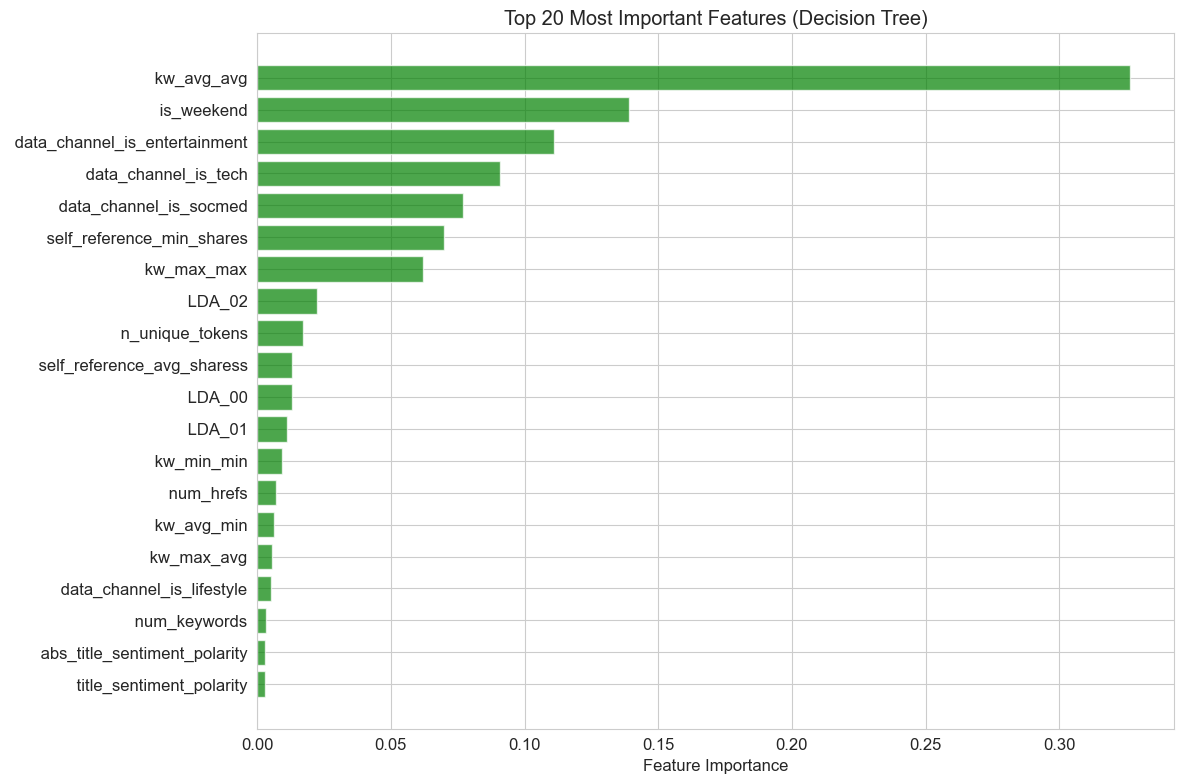


Decision Tree Structure:
  Tree depth: 5
  Number of leaves: 32
  Number of nodes: 63

Analyzing overfitting with different max_depth values...


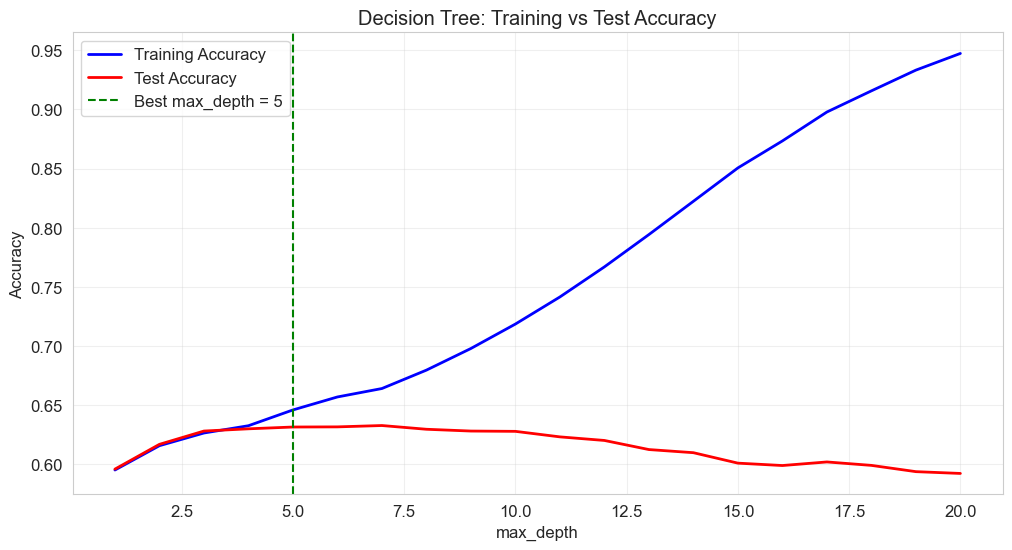


Decision Tree analysis complete!
Best Decision Tree model: max_depth=5, min_samples_split=2
Test Accuracy: 0.6316


In [41]:
# Part 8: Decision Tree Classification
print("="*60)
print("DECISION TREE CLASSIFICATION")
print("="*60)

print("Tuning Decision Tree parameters using GridSearchCV...")

# Define parameter grid for GridSearch
param_grid = {
    'max_depth': [5, 10, 15, 20, 25, None],
    'min_samples_split': [2, 5, 10, 20, 50]
}

print(f"Parameter grid:")
print(f"  max_depth: {param_grid['max_depth']}")
print(f"  min_samples_split: {param_grid['min_samples_split']}")
print(f"Total combinations: {len(param_grid['max_depth']) * len(param_grid['min_samples_split'])}")

# Create GridSearchCV object
dt_grid = GridSearchCV(
    DecisionTreeClassifier(random_state=RANDOM_STATE),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,  # Use all available cores
    verbose=1
)

print(f"\nRunning GridSearchCV (this may take a few minutes)...")
# Note: Decision trees don't require scaled data, so we use original X_train
dt_grid.fit(X_train, y_train)

# Get best parameters
best_params = dt_grid.best_params_
best_dt_cv_score = dt_grid.best_score_

print(f"\nBest parameters found:")
print(f"  max_depth: {best_params['max_depth']}")
print(f"  min_samples_split: {best_params['min_samples_split']}")
print(f"Best cross-validation score: {best_dt_cv_score:.4f} ({best_dt_cv_score*100:.2f}%)")

# Visualize parameter tuning results
results_df = pd.DataFrame(dt_grid.cv_results_)

# Create a pivot table for heatmap
pivot_table = results_df.pivot_table(
    values='mean_test_score',
    index='param_min_samples_split',
    columns='param_max_depth',
    aggfunc='mean'
)

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt='.4f', cmap='YlOrRd', cbar_kws={'label': 'CV Accuracy'})
plt.title('Decision Tree Parameter Tuning Results')
plt.xlabel('max_depth')
plt.ylabel('min_samples_split')
plt.show()

# Train final decision tree with best parameters
print(f"\nTraining final Decision Tree model...")
final_dt = DecisionTreeClassifier(
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    random_state=RANDOM_STATE
)
final_dt.fit(X_train, y_train)

# Make predictions
y_pred_dt = final_dt.predict(X_test)
dt_test_accuracy = accuracy_score(y_test, y_pred_dt)

print(f"Decision Tree Test Accuracy: {dt_test_accuracy:.4f} ({dt_test_accuracy*100:.2f}%)")

# Classification report
print(f"\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_dt, target_names=['Unpopular', 'Popular']))

# Confusion matrix
cm_dt = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Greens',
           xticklabels=['Unpopular', 'Popular'],
           yticklabels=['Unpopular', 'Popular'])
plt.title('Decision Tree Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Feature importance analysis
feature_importance = final_dt.feature_importances_
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print(f"\nTop 15 Most Important Features:")
print("Rank | Feature                          | Importance")
print("-" * 55)
for i, (_, row) in enumerate(importance_df.head(15).iterrows()):
    print(f" {i+1:2d}  | {row['feature']:<30} | {row['importance']:.4f}")

# Visualize top feature importances
plt.figure(figsize=(12, 8))
top_features = importance_df.head(20)
plt.barh(range(len(top_features)), top_features['importance'], color='green', alpha=0.7)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 20 Most Important Features (Decision Tree)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Analyze tree structure
print(f"\nDecision Tree Structure:")
print(f"  Tree depth: {final_dt.get_depth()}")
print(f"  Number of leaves: {final_dt.get_n_leaves()}")
print(f"  Number of nodes: {final_dt.tree_.node_count}")

# Test different max_depth values to show overfitting
print(f"\nAnalyzing overfitting with different max_depth values...")
depths = range(1, 21)
train_scores = []
test_scores = []

for depth in depths:
    dt_temp = DecisionTreeClassifier(max_depth=depth, random_state=RANDOM_STATE)
    dt_temp.fit(X_train, y_train)

    train_pred = dt_temp.predict(X_train)
    test_pred = dt_temp.predict(X_test)

    train_scores.append(accuracy_score(y_train, train_pred))
    test_scores.append(accuracy_score(y_test, test_pred))

# Plot overfitting analysis
plt.figure(figsize=(12, 6))
plt.plot(depths, train_scores, 'b-', linewidth=2, label='Training Accuracy')
plt.plot(depths, test_scores, 'r-', linewidth=2, label='Test Accuracy')
plt.axvline(x=best_params['max_depth'] if best_params['max_depth'] else 20,
           color='green', linestyle='--', label=f'Best max_depth = {best_params["max_depth"]}')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title('Decision Tree: Training vs Test Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nDecision Tree analysis complete!")
print(f"Best Decision Tree model: max_depth={best_params['max_depth']}, min_samples_split={best_params['min_samples_split']}")
print(f"Test Accuracy: {dt_test_accuracy:.4f}")

FINAL COMPARISON AND CONCLUSIONS

PERFORMANCE SUMMARY
             Algorithm                      Best Parameters  CV Score  Test Accuracy
   K-Nearest Neighbors                               k = 29  0.631499       0.641821
Support Vector Machine                                C = 1  0.650800       0.660361
         Decision Tree max_depth = 5, min_samples_split = 2  0.634999       0.631605

BEST PERFORMING ALGORITHM: Support Vector Machine
Test Accuracy: 0.6604 (66.04%)


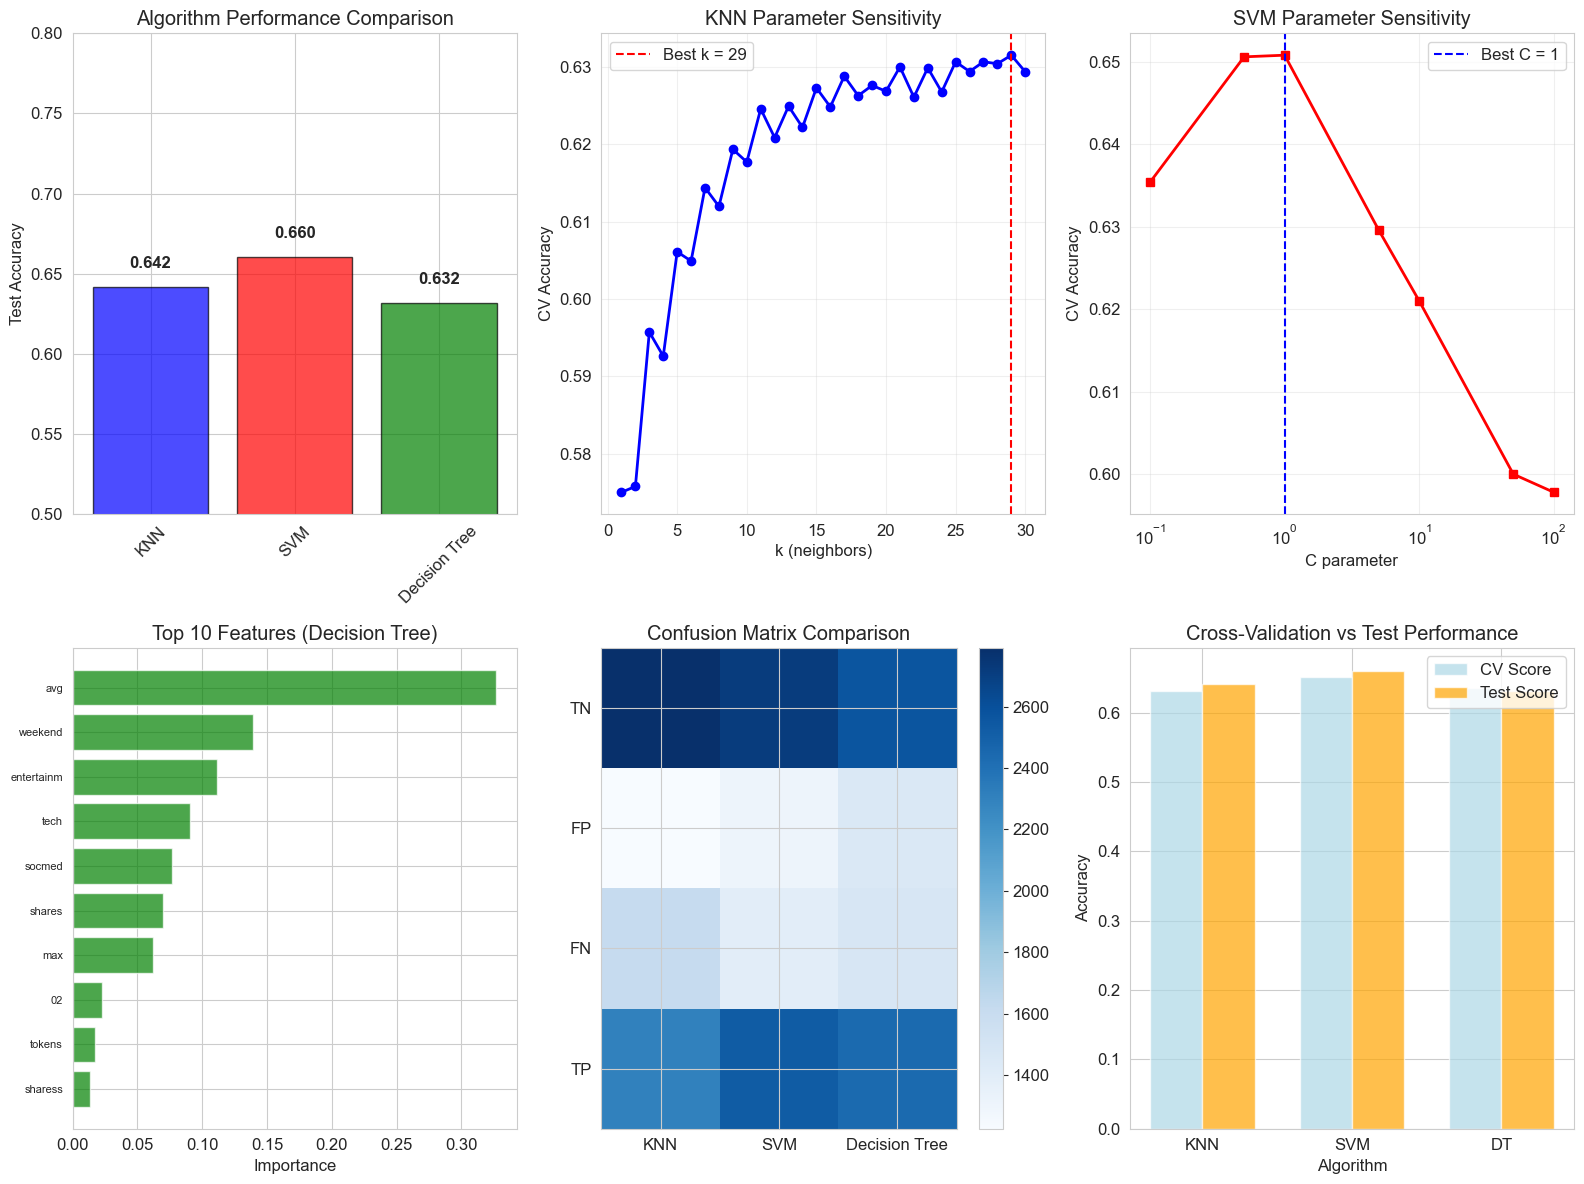


ANSWERING ASSIGNMENT QUESTIONS

1. WHICH METHOD WORKED BEST?
----------------------------------------
Ranking by test accuracy:
  1. Support Vector Machine: 0.6604
  2. K-Nearest Neighbors: 0.6418
  3. Decision Tree: 0.6316

The Support Vector Machine performed best with 0.6604 accuracy.
Performance gap from best to second: 0.0185

2. HOW DID DIFFERENT PARAMETERS INFLUENCE ACCURACY?
--------------------------------------------------
KNN (k parameter):
  - Best k: 29
  - k=1 accuracy: 0.5750 (high variance)
  - k=30 accuracy: 0.6294 (high bias)
  - Optimal k balances bias-variance tradeoff

SVM (C parameter):
  - Best C: 1
  - Low C (C=0.1): 0.6354 (underfitting)
  - High C (C=100): 0.5978 (potential overfitting)
  - C controls regularization strength

Decision Tree:
  - Best max_depth: 5
  - Best min_samples_split: 2
  - Shallow trees underfit, deep trees overfit

3. WHICH MODEL IS EASIEST TO INTERPRET?
---------------------------------------------
  1. Decision Tree: High - Can visua

In [42]:
# Part 9: Final Comparison and Conclusions
print("="*70)
print("FINAL COMPARISON AND CONCLUSIONS")
print("="*70)

# Compile results
results = {
    'Algorithm': ['K-Nearest Neighbors', 'Support Vector Machine', 'Decision Tree'],
    'Best Parameters': [
        f'k = {best_k}',
        f'C = {best_C}',
        f'max_depth = {best_params["max_depth"]}, min_samples_split = {best_params["min_samples_split"]}'
    ],
    'CV Score': [best_cv_score, best_svm_cv_score, best_dt_cv_score],
    'Test Accuracy': [knn_test_accuracy, svm_test_accuracy, dt_test_accuracy]
}

results_df = pd.DataFrame(results)
print("\nPERFORMANCE SUMMARY")
print("="*50)
print(results_df.to_string(index=False))

# Determine best performing algorithm
best_algorithm_idx = np.argmax(results_df['Test Accuracy'])
best_algorithm = results_df.iloc[best_algorithm_idx]['Algorithm']
best_test_score = results_df.iloc[best_algorithm_idx]['Test Accuracy']

print(f"\nBEST PERFORMING ALGORITHM: {best_algorithm}")
print(f"Test Accuracy: {best_test_score:.4f} ({best_test_score*100:.2f}%)")

# Create comprehensive visualization
fig = plt.figure(figsize=(16, 12))

# 1. Algorithm comparison
ax1 = plt.subplot(2, 3, 1)
algorithms = results_df['Algorithm']
test_scores = results_df['Test Accuracy']
colors = ['blue', 'red', 'green']

bars = ax1.bar(range(len(algorithms)), test_scores, color=colors, alpha=0.7, edgecolor='black')
ax1.set_ylabel('Test Accuracy')
ax1.set_title('Algorithm Performance Comparison')
ax1.set_xticks(range(len(algorithms)))
ax1.set_xticklabels(['KNN', 'SVM', 'Decision Tree'], rotation=45)
ax1.set_ylim(0.5, 0.8)

for bar, score in zip(bars, test_scores):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

# 2. Parameter sensitivity (KNN)
ax2 = plt.subplot(2, 3, 2)
ax2.plot(k_values, cv_scores_knn, 'b-', linewidth=2, marker='o')
ax2.axvline(x=best_k, color='r', linestyle='--', label=f'Best k = {best_k}')
ax2.set_xlabel('k (neighbors)')
ax2.set_ylabel('CV Accuracy')
ax2.set_title('KNN Parameter Sensitivity')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Parameter sensitivity (SVM)
ax3 = plt.subplot(2, 3, 3)
ax3.plot(C_values, cv_scores_svm, 'r-', linewidth=2, marker='s')
ax3.axvline(x=best_C, color='blue', linestyle='--', label=f'Best C = {best_C}')
ax3.set_xlabel('C parameter')
ax3.set_ylabel('CV Accuracy')
ax3.set_title('SVM Parameter Sensitivity')
ax3.set_xscale('log')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Feature importance (Decision Tree)
ax4 = plt.subplot(2, 3, 4)
top_10_features = importance_df.head(10)
ax4.barh(range(len(top_10_features)), top_10_features['importance'], color='green', alpha=0.7)
ax4.set_yticks(range(len(top_10_features)))
ax4.set_yticklabels([f.split('_')[-1][:10] for f in top_10_features['feature']], fontsize=8)
ax4.set_xlabel('Importance')
ax4.set_title('Top 10 Features (Decision Tree)')
ax4.invert_yaxis()

# 5. Confusion matrices comparison
ax5 = plt.subplot(2, 3, 5)
# Create a side-by-side confusion matrix comparison
cm_combined = np.column_stack([cm_knn.flatten(), cm_svm.flatten(), cm_dt.flatten()])
im = ax5.imshow(cm_combined, cmap='Blues', aspect='auto')
ax5.set_xticks([0, 1, 2])
ax5.set_xticklabels(['KNN', 'SVM', 'Decision Tree'])
ax5.set_yticks([0, 1, 2, 3])
ax5.set_yticklabels(['TN', 'FP', 'FN', 'TP'])
ax5.set_title('Confusion Matrix Comparison')
plt.colorbar(im, ax=ax5)

# 6. Cross-validation vs Test performance
ax6 = plt.subplot(2, 3, 6)
cv_scores = results_df['CV Score']
test_scores = results_df['Test Accuracy']
x_pos = np.arange(len(algorithms))

width = 0.35
ax6.bar(x_pos - width/2, cv_scores, width, label='CV Score', alpha=0.7, color='lightblue')
ax6.bar(x_pos + width/2, test_scores, width, label='Test Score', alpha=0.7, color='orange')
ax6.set_xlabel('Algorithm')
ax6.set_ylabel('Accuracy')
ax6.set_title('Cross-Validation vs Test Performance')
ax6.set_xticks(x_pos)
ax6.set_xticklabels(['KNN', 'SVM', 'DT'])
ax6.legend()

plt.tight_layout()
plt.show()

# Answer the assignment questions
print("\n" + "="*70)
print("ANSWERING ASSIGNMENT QUESTIONS")
print("="*70)

print("\n1. WHICH METHOD WORKED BEST?")
print("-" * 40)
sorted_results = results_df.sort_values('Test Accuracy', ascending=False)
print(f"Ranking by test accuracy:")
for i, (_, row) in enumerate(sorted_results.iterrows()):
    print(f"  {i+1}. {row['Algorithm']}: {row['Test Accuracy']:.4f}")

print(f"\nThe {best_algorithm} performed best with {best_test_score:.4f} accuracy.")

performance_gap = sorted_results.iloc[0]['Test Accuracy'] - sorted_results.iloc[1]['Test Accuracy']
print(f"Performance gap from best to second: {performance_gap:.4f}")

print("\n2. HOW DID DIFFERENT PARAMETERS INFLUENCE ACCURACY?")
print("-" * 50)

print(f"KNN (k parameter):")
print(f"  - Best k: {best_k}")
print(f"  - k=1 accuracy: {cv_scores_knn[0]:.4f} (high variance)")
print(f"  - k=30 accuracy: {cv_scores_knn[-1]:.4f} (high bias)")
print(f"  - Optimal k balances bias-variance tradeoff")

print(f"\nSVM (C parameter):")
print(f"  - Best C: {best_C}")
print(f"  - Low C (C=0.1): {cv_scores_svm[0]:.4f} (underfitting)")
print(f"  - High C (C=100): {cv_scores_svm[-1]:.4f} (potential overfitting)")
print(f"  - C controls regularization strength")

print(f"\nDecision Tree:")
print(f"  - Best max_depth: {best_params['max_depth']}")
print(f"  - Best min_samples_split: {best_params['min_samples_split']}")
print(f"  - Shallow trees underfit, deep trees overfit")

print("\n3. WHICH MODEL IS EASIEST TO INTERPRET?")
print("-" * 45)
interpretability_ranking = [
    ("Decision Tree", "High - Can visualize rules and feature importance"),
    ("KNN", "Medium - Can examine nearest neighbors for predictions"),
    ("SVM", "Low - Complex decision boundary in high-dimensional space")
]

for i, (model, description) in enumerate(interpretability_ranking):
    print(f"  {i+1}. {model}: {description}")

print(f"\nDecision Tree is most interpretable because:")
print(f"  - Clear if-then rules")
print(f"  - Feature importance rankings")
print(f"  - Visual tree structure")
print(f"  - No need for feature scaling")

print("\n4. HOW TO INTERPRET THE RESULTS?")
print("-" * 40)

print(f"Model Performance:")
print(f"  - All models achieve ~{np.mean(test_scores):.1%} accuracy")
print(f"  - This is better than random (50%) but moderate overall")
print(f"  - Suggests online news popularity is partially predictable")

print(f"\nData Insights:")
median_popularity = y.mean()
print(f"  - {median_popularity:.1%} of articles are 'popular' (above median shares)")
print(f"  - Balanced classification problem")

if 'importance_df' in locals():
    top_feature = importance_df.iloc[0]['feature']
    print(f"  - Most important feature: {top_feature}")
    print(f"  - Feature importance suggests content attributes matter")

print(f"\nBusiness Implications:")
print(f"  - News popularity has some predictable patterns")
print(f"  - Content features and publication timing influence shares")
print(f"  - Models could help optimize content strategy")
print(f"  - Room for improvement with more sophisticated features")

print("\n5. RECOMMENDATIONS")
print("-" * 25)
print(f"Based on this analysis:")
print(f"  1. Use {best_algorithm} for best performance")
print(f"  2. Use Decision Tree for interpretability")
print(f"  3. Feature engineering could improve all models")
print(f"  4. Ensemble methods might boost performance")
print(f"  5. Consider the business cost of false positives vs false negatives")

print(f"\nAnalysis complete! 🎉")
print(f"The best model achieves {best_test_score:.1%} accuracy predicting news popularity.")